## Setup / packages / crs

In [1]:
import geopandas as gp
from shapely import wkt
import pandas as pd
import pprint
import os
import glob
import openpyxl
import matplotlib.pyplot as plt
import plotly.express as px #if using plotly

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
worldmap = gp.read_file(gp.datasets.get_path("naturalearth_lowres"))
usa = gp.read_file("data/cb_2018_us_nation_5m.shp")
us_states = gp.read_file("data/cb_2018_us_state_500k.shp")
ca_state = gp.read_file("/Users/natebender/Desktop/repo/capstone_rmi/data/CA_State_TIGER2016.shp")
ca_counties = gp.read_file("/Users/natebender/Desktop/repo/capstone_rmi/data/CA_Counties_TIGER2016.shp")

In [4]:
# set common crs for project
projcrs = 4326
us_states = us_states.to_crs(projcrs)  # match us_states common crs for project
worldmap = worldmap.to_crs(projcrs)
ca_state = ca_state.to_crs(projcrs)
ca_counties = ca_counties.to_crs(projcrs)

In [5]:
# read in Refineries

cols = list(pd.read_csv("data/asset-climate-trace_oil-refining_091922.csv", nrows =1))
refs = pd.read_csv("data/asset-climate-trace_oil-refining_091922.csv", 
                   usecols = lambda x: x not in ['other1', 'other2', 'other3', 
                                                 'other4', 'other5', 'other6', 'other7'])
refs['location'] = gp.GeoSeries.from_wkt(refs['location'])  # convert existing points to geoseries
refs = gp.GeoDataFrame(refs, geometry="location", crs=projcrs)  # convert df to geodf

In [6]:
# read in cleaned and combined flares data
all_flares = gp.read_file("data/all_flares.shp")

In [7]:
# check 
all_flares.head(3)

,Country,ISO Code,Catalog ID,id #,Latitude,Longitude,BCM_2019,avg_temp,Ellipticit,Detection_,clr_obs19,Type,ID 2020,BCM_2020,Avg. temp.,Det_freq20,clr_obs20,ID 2021,BCM_2021,Det_freq21,clr_obs21,id_key_201,Avg_Temp_K,Det_freq17,clr_obs17,ISO_Code,BCM_2017,id_key,BCM_2012,BCM_2013,BCM_2014,BCM_2015,BCM_2016,clr_obs12,clr_obs13,clr_obs14,clr_obs15,clr_obs16,Det_freq12,Det_freq13,Det_freq14,Det_freq15,Det_freq16,Catalog _1,BCM_2018,Det_freq18,clr_obs18,flare_cate,Detection,Det_freq19,geometry
0,Venezuela,VEN,VEN_UPS_2015_63.6235W_9.6520N_v0.2,3591.0,9.652042,-63.623525,1.167234,1839.27,1.60150,100.0000,112.0,upstream,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,flares_upstream,NaN,NaN,POINT (-63.62353 9.65204)
1,Iraq,IRQ,IRQ_UPS_2015_47.2834E_31.0259N_v0.2,6116.0,31.025901,47.283392,1.092002,1651.94,4.78228,83.5821,67.0,upstream,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,flares_upstream,NaN,NaN,POINT (47.28339 31.02590)
2,Iran,IRN,IRN_UPS_2015_49.7141E_28.4940N_v0.2,6450.0,28.494039,49.714096,0.947876,1658.76,2.31782,100.0000,265.0,upstream,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,flares_upstream,NaN,NaN,POINT (49.71410 28.49404)


In [8]:
len(all_flares)

74289

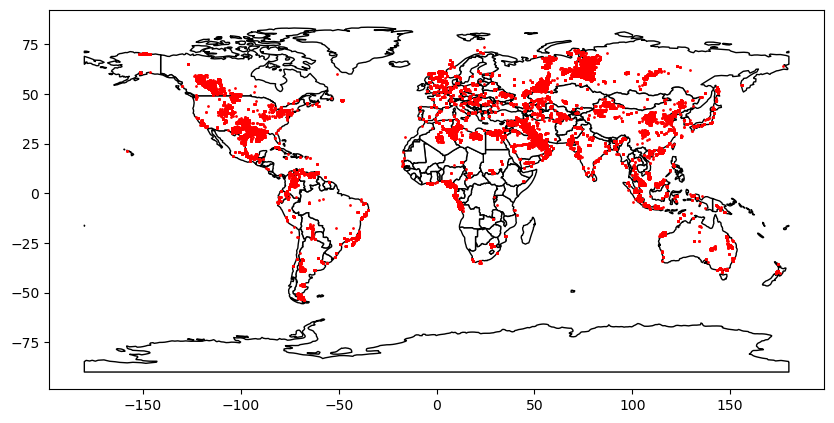

In [9]:
# see where the flares are across the world

fig, ax = plt.subplots(figsize = (10,8))
worldmap.plot(ax = ax, color = 'white', edgecolor = 'black')
all_flares.plot(ax = ax, color='red', markersize=1)  # increase size for visibility
plt.show()

### US / CA analysis

In [10]:
# subset to just lower 48 plus AK
# remove territories (PR, PW, VI, MH, GU) and AK, HI
stateslist = ["AL","AR","AZ","CA","CO","CT","DC","DE","FL","GA","IA","ID", "IL","IN","KS","KY","LA","MA","MD","ME","MI","MN","MO","MS","MT","NC","ND","NE","NH","NJ","NM","NV","NY", "OH","OK","OR","PA","RI","SC","SD","TN","TX","UT","VA","VT","WA","WI","WV","WY"]
us_states = us_states[us_states['STUSPS'].isin(stateslist)]

In [22]:
# match all flares and refineries with just CA counties
inner_join_result = gp.sjoin(all_flares, ca_counties, how = "inner", predicate = 'within')
refs_join = gp.sjoin(refs, ca_counties, how='inner', predicate='within')
print(f'Flares found: {len(inner_join_result)}')

Flares found: 117


In [12]:
len(inner_join_result)

117

In [13]:
col_list = ['BCM_2012','BCM_2013','BCM_2014','BCM_2015','BCM_2016','BCM_2017',
            'BCM_2018','BCM_2019','BCM_2020','BCM_2021']

# calc mean by year
inner_join_result['BCM_avg'] = inner_join_result[col_list].mean(axis=1)

In [14]:
inner_join_result

,Country,ISO Code,Catalog ID,id #,Latitude,Longitude,BCM_2019,avg_temp,Ellipticit,Detection_,clr_obs19,Type,ID 2020,BCM_2020,Avg. temp.,Det_freq20,clr_obs20,ID 2021,BCM_2021,Det_freq21,clr_obs21,id_key_201,Avg_Temp_K,Det_freq17,clr_obs17,ISO_Code,BCM_2017,id_key,BCM_2012,BCM_2013,BCM_2014,BCM_2015,BCM_2016,clr_obs12,clr_obs13,clr_obs14,clr_obs15,clr_obs16,Det_freq12,Det_freq13,Det_freq14,Det_freq15,Det_freq16,Catalog _1,BCM_2018,Det_freq18,clr_obs18,flare_cate,Detection,Det_freq19,geometry,index_right,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,BCM_avg
3359,United States,USA,USA_UPS_2015_118.8924W_34.4787N_v0.2,1010.0,34.478658,-118.892406,0.006512,1896.56,1.62683,20.33430,359.0,upstream,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,flares_upstream,NaN,NaN,POINT (-118.89241 34.47866),4,06,111,00277320,06111,Ventura,Ventura County,06,H1,G4020,348,37100,None,A,4773390489,945942791,+34.3587415,-119.1331432,0.006512
5356,United States,USA,USA_UPS_2015_119.4557W_34.3722N_v0.2,1003.0,34.372179,-119.455722,0.001944,1790.00,1.70278,11.67880,274.0,upstream,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,flares_upstream,NaN,NaN,POINT (-119.45572 34.37218),4,06,111,00277320,06111,Ventura,Ventura County,06,H1,G4020,348,37100,None,A,4773390489,945942791,+34.3587415,-119.1331432,0.001944
5617,United States,USA,USA_UPS_2015_118.7840W_34.3740N_v0.2,1012.0,34.374022,-118.784005,0.001616,1822.63,1.60150,14.80450,358.0,upstream,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,flares_upstream,NaN,NaN,POINT (-118.78400 34.37402),4,06,111,00277320,06111,Ventura,Ventura County,06,H1,G4020,348,37100,None,A,4773390489,945942791,+34.3587415,-119.1331432,0.001616
5684,United States,USA,USA_UPS_2015_119.2662W_34.3126N_v0.2,1006.0,34.312614,-119.266152,0.001530,1850.95,1.60150,3.45912,318.0,upstream,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,flares_upstream,NaN,NaN,POINT (-119.26615 34.31261),4,06,111,00277320,06111,Ventura,Ventura County,06,H1,G4020,348,37100,None,A,4773390489,945942791,+34.3587415,-119.1331432,0.001530
6730,United States,USA,USA_UPS_2015_119.3177W_34.3169N_v0.2,1005.0,34.316921,-119.317663,0.000641,1928.91,1.60150,3.23625,309.0,upstream,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,flares_upstream,NaN,NaN,POINT (-119.31766 34.31692),4,06,111,00277320,06111,Ventura,Ventura County,06,H1,G4020,348,37100,None,A,4773390489,945942791,+34.3587415,-119.1331432,0.000641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71227,United States,None,None,NaN,33.775517,-118.216817,NaN,NaN,1.60150,NaN,NaN,refinery,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1327.29,NaN,NaN,USA,NaN,VNF_e2012-2015_n6042_x1182168W_y337755N_v1.0,0.000118,0.000499,0.000752,0.000707,0.000254,349.0,423.0,420.0,397.0,415.0,0.859599,2.83688,4.52381,4.53401,1.445780,None,NaN,NaN,NaN,flares_oil_downstream,NaN,NaN,POINT (-118.21682 33.77552),5,06,037,00277283,06037,Los Angeles,Los Angeles County,06,H1,G4020,348,31080,31084,A,10510651024,1794730436,+34.1963983,-118.2618616,0.000466
72760,United States,USA,None,1608.0,33.774628,-118.216837,NaN,NaN,1.60150,NaN,NaN,refinery,NaN,NaN,1317.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,USA_

### Visualization

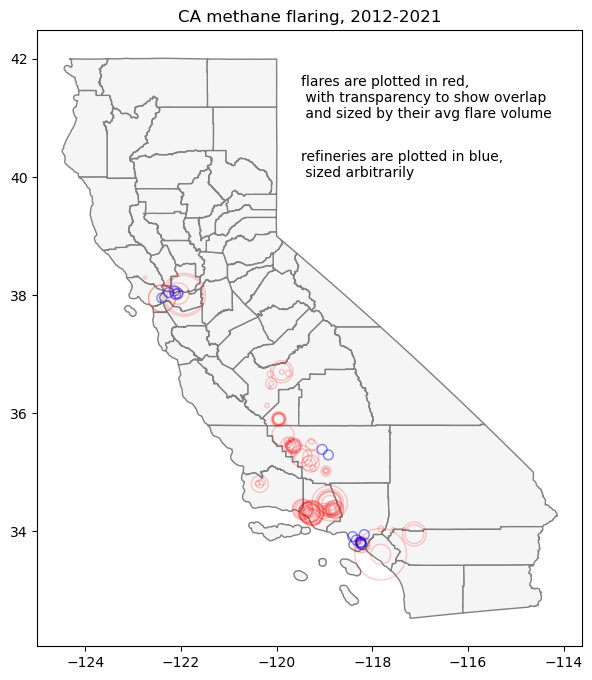

In [15]:
# # Plotting multiple layers

fig, ax = plt.subplots(figsize = (10,8))
#worldmap.plot(ax = ax, color = 'white', edgecolor = 'black')
#us_states.plot(ax = ax, color = 'whitesmoke', edgecolor = 'black')
ca_counties.plot(ax = ax, color = 'whitesmoke', edgecolor = 'grey')
# increase size by 100000 just for readability
inner_join_result.plot(ax = ax, facecolors='none', color = 'red', alpha=.2, markersize=inner_join_result[col_list].mean(axis=1)*100000)
refs_join.plot(ax = ax, facecolors = 'none', color = 'blue', alpha = .08, markersize=50)
#plt.ylim([33, 39])  # can zoom for readability
plt.title("CA methane flaring, 2012-2021")
plt.text(-119.5,41, 'flares are plotted in red,\n with transparency to show overlap\n and sized by their avg flare volume')
plt.text(-119.5,40, 'refineries are plotted in blue,\n sized arbitrarily')
plt.show()

## California: BCM by county

In [16]:
ca_flares = gp.sjoin(all_flares, ca_counties, how = "inner", op = 'within')
# rename so county names col is clear
ca_flares.rename(columns={'NAME':'county_name'}, inplace=True)

/Users/natebender/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [17]:
# Create df of total BCM by year, grouped by CA county

col_list = ['BCM_2012','BCM_2013','BCM_2014','BCM_2015','BCM_2016','BCM_2017',
            'BCM_2018','BCM_2019','BCM_2020','BCM_2021']

stats = ca_flares.groupby(['county_name'])[col_list].sum()
stats['Total_bcm'] = stats.loc[:,col_list].sum(axis=1)

In [18]:
stats.sort_values('Total_bcm', ascending=False)

,BCM_2012,BCM_2013,BCM_2014,BCM_2015,BCM_2016,BCM_2017,BCM_2018,BCM_2019,BCM_2020,BCM_2021,Total_bcm
county_name,,,,,,,,,,,
Ventura,0.012710,0.010459,0.014991,0.014626,0.010991,0.007965,0.013832,0.012244,0.010266,0.007006,0.115091
Kern,0.022107,0.017479,0.006143,0.004658,0.004097,0.001750,0.001857,0.001513,0.001847,0.002424,0.063874
Contra Costa,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016525,0.012624,0.029149
Orange,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013800,0.002061,0.015861
Kings,0.000113,0.000184,0.000466,0.002189,0.001324,0.000832,0.001163,0.000762,0.000651,0.000527,0.008210
Los Angeles,0.000461,0.000566,0.000928,0.000969,0.001372,0.000441,0.000450,0.000000,0.001092,0.001398,0.007675
Fresno,0.000000,0.000000,0.000000,0.000000,0.002157,0.000000,0.000356,0.000627,0.001563,0.002572,0.007275
Riverside,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001856,0.000000,0.000000,0.002968,0.004824
Santa Barbara,0.000279,0.000206,0.000099,0.000000,0.000000,0.000304,0.001694,0.000000,0.000000,0.000000,0.002583


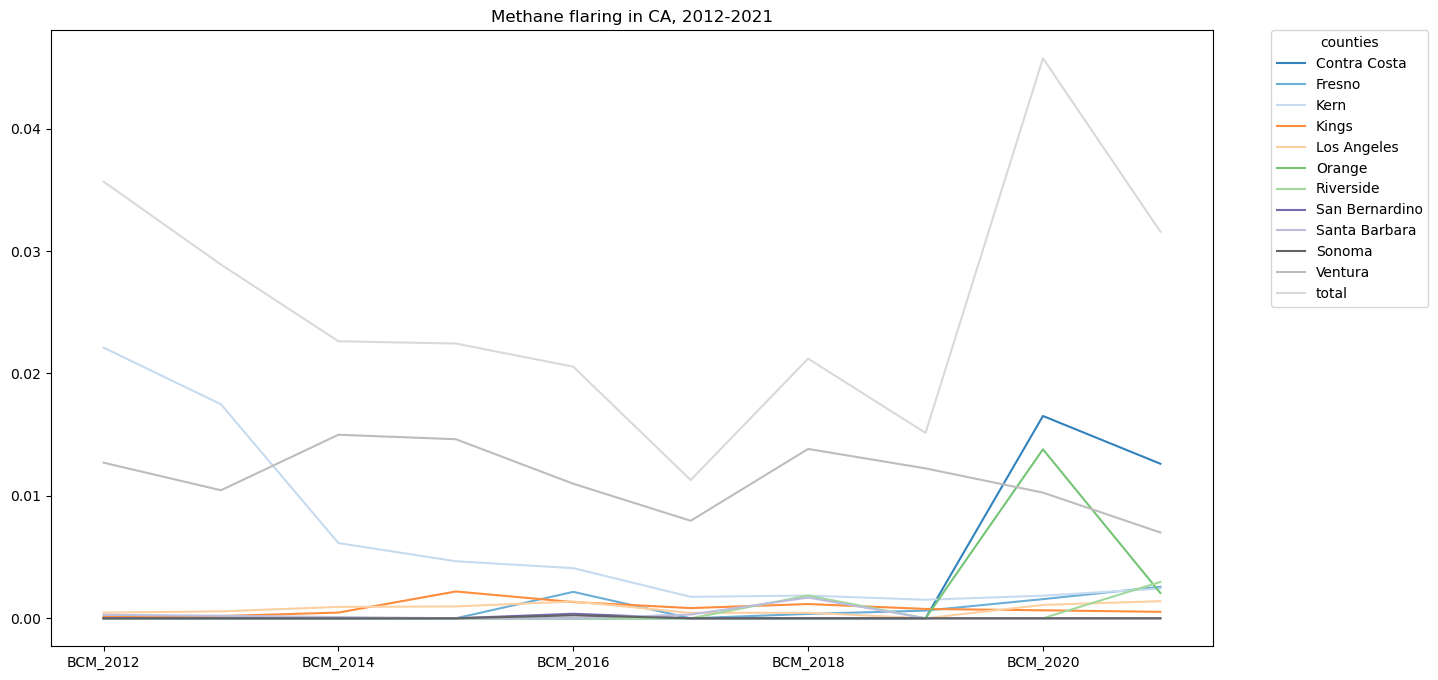

In [19]:
forplot = stats.drop(['Total_bcm'], axis=1)
forplot.loc['total'] = forplot.sum()
forplot = forplot.transpose() 

plot = forplot.plot(kind = 'line', title = 'Methane flaring in CA, 2012-2021', colormap='tab20c', figsize = [15, 8])
plot.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title='counties')

## California: BCM by flare category (upstream, downstream oil, downstream gas)

In [23]:
col_list = ['BCM_2012','BCM_2013','BCM_2014','BCM_2015','BCM_2016','BCM_2017',
            'BCM_2018','BCM_2019','BCM_2020','BCM_2021']

stats = all_flares.groupby(['flare_cate'])[col_list].sum()
stats['Total_cat'] = stats.loc[:,col_list].sum(axis=1)
stats.loc['Total'] = stats.sum()

In [24]:
# table of BCM totals by flare category and year. Ignore the meaningless value at the intersection of
# the two totals
stats

,BCM_2012,BCM_2013,BCM_2014,BCM_2015,BCM_2016,BCM_2017,BCM_2018,BCM_2019,BCM_2020,BCM_2021,Total_cat
flare_cate,,,,,,,,,,,
flares_gas_downstream,3.148050,2.995011,3.287280,2.699374,2.790568,3.132377,2.819118,4.996976,3.553781,3.590534,33.013068
flares_oil_downstream,11.924196,11.361305,10.860963,10.603512,10.627614,9.795036,9.973826,12.013552,10.075499,11.703417,108.938921
flares_upstream,139.579289,136.955262,141.034803,143.605785,146.630434,138.457666,142.216780,143.680086,138.807759,140.925379,1411.893243
Total,154.651535,151.311578,155.183046,156.908671,160.048615,151.385079,155.009723,160.690614,152.437039,156.219330,1553.845231


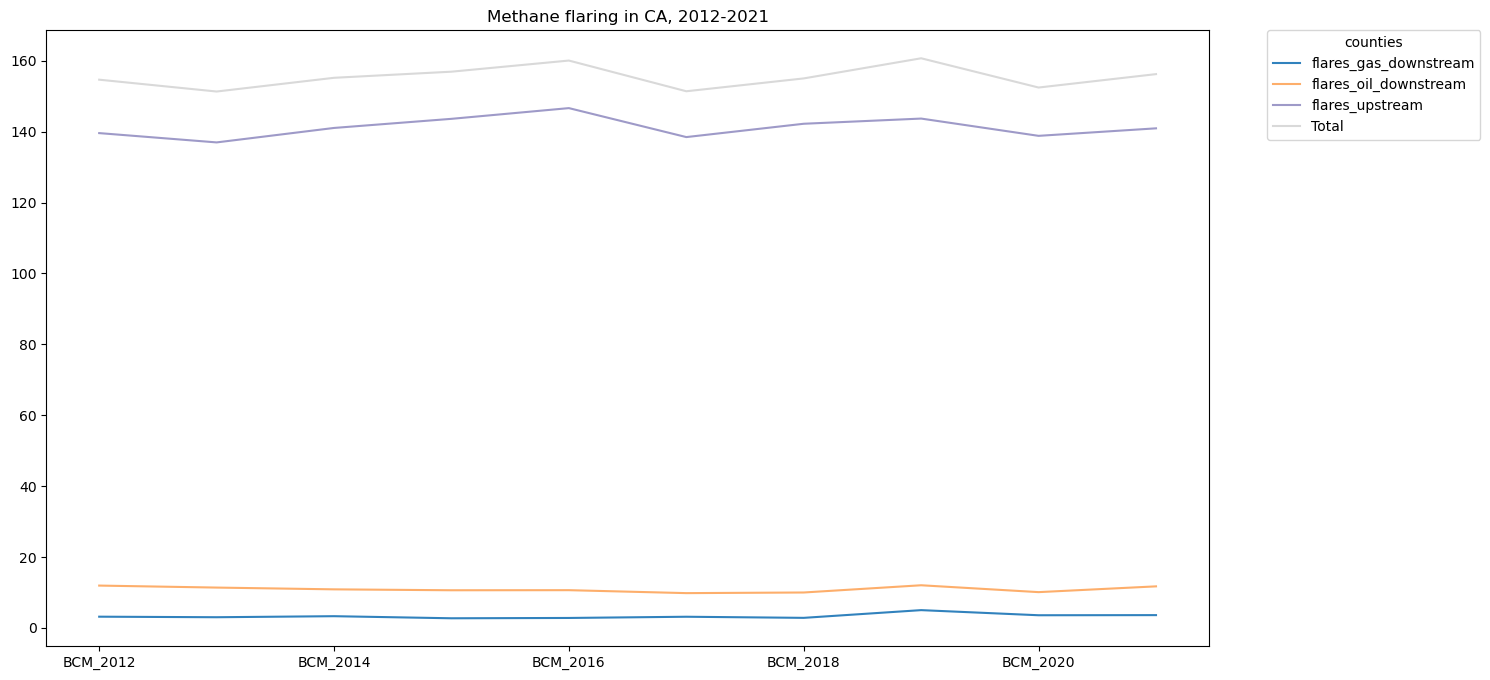

In [25]:
forplot = stats.drop(['Total_cat'], axis=1)
forplot = forplot.transpose() 

plot = forplot.plot(kind = 'line', title = 'Methane flaring in CA, 2012-2021', colormap='tab20c', figsize = [15, 8])
plot.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title='counties')